In [254]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import scale, LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%cd /home/kenji/Projects/BasicProjects/KMeans_Numbers

/home/kenji/Projects/BasicProjects/KMeans_Numbers


In [3]:
## DATA
# Import/Load
#  Examine
# Missing Values?
#  Value Counts
## EDA: Initial Summary Statistics
## Visualization: Summary Statistics
## Preprocess Data
#  Normailze?
## EDA: Feature Importance/Selection
# Convariance: Strength of Linear Relationships
## Visualization: Feature Relations
## Data Wrangling
## Modelling
# #Fit/Train Model
# Evaluate Model
# Visualization: Communicating Findings

In [ ]:
## DATA


#https://archive-beta.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping
# Import/Load

import pickle
import glob
tsv_files = glob.glob("Data/*.tsv")
database = {}
for file in tsv_files:
    data = pd.read_table(file,low_memory=False,na_values=['\\N','nan'])
    #TODO use regex or something to clean up file name/key.
    database[file] = data
    print(f'{file} has been added to our database.')
    
#keep for now, might be needed for deploymentfor possibly pickling for later storage.
#

In [ ]:
#  Examine
# print(data.describe(),'\n')
def get_multi_info(database):
    for name,data in database.items():
        print(name)
        print(data.info(),'\n')

get_multi_info(database)

In [ ]:
keep_basics = ['tconst','titleType','primaryTitle','startYear','runtimeMinutes','genres']
keep_principals = ['tconst','ordering','nconst','category','job','characters']
keep_ratings = ['tconst','averageRating','numVotes']
keep_crew = ['tconst','directors','writers']
keep_name = ['nconst','primaryName','birthYear','primaryProfession','knownForTitles']

In [ ]:
#TODO Get rid of all of this, just make the date_ off the bat. Expensive trial and error is done.
data_basics = database['Data/basics.tsv'][keep_basics]
data_principals = database['Data/principals.tsv'][keep_principals]
data_ratings = database['Data/ratings.tsv'][keep_ratings]
data_crew = database['Data/crew.tsv'][keep_crew]
data_name = database['Data/name.tsv'][keep_name]

In [ ]:
data_basics = data_basics[data_basics.startYear.between(1900, 1949)]

In [ ]:
genres = data_basics.genres.unique().tolist()
horrors = [genre for genre in genres if str(genre).find('Horror') !=-1 ]

In [ ]:
data_basics = data_basics.loc[data_basics['genres'].isin(horrors)]

In [ ]:
data_basics = data_basics[data_basics.titleType == 'movie']

In [ ]:
data_basics.drop('titleType', axis=1,inplace=True)

In [ ]:
data_basics.dropna(subset=['runtimeMinutes'],inplace=True)

In [ ]:
data_principals.drop(['job','characters'], axis=1,inplace=True)
data_principals

In [ ]:
data = data_basics.merge(data_principals, how='left',on='tconst')

In [ ]:
data = data.merge(data_name, how='left',on='nconst')

In [ ]:
data = data.merge(data_ratings, how='left',on='tconst')

In [ ]:
data = data.merge(data_crew, how='left',on='tconst')

In [ ]:
data.drop('birthYear', axis=1,inplace=True)

In [ ]:
# Missing Values?
def missing_data(data):
    total = 0
    maxi = 0
    for i in data.columns:
        print(f'Checking {i}')
        missing = data[i].isnull().sum()
        if missing > 0:
            total+=missing
            if missing > maxi:
                maxi = missing
            print(f'Missing: {data[i].isnull().sum()}\n')
        else:
            print(f'Nothing Missing in {i}\n')
    if total != 0:
        print(f'Missing {total} out of {len(data)} records, {round(maxi/len(data)*100)}% to {round(total/len(data)*100)}%')
    else:
        print(f'Nothing Missing\n')
missing_data(data)

In [ ]:
def get_multi_cols_counts(data):
    for i in data:
        print(f"Columns:\n")
        for j in data.columns:
            print(j)
        #print(f'\nChecking {name} Unique Values: \n')
        
        #print(f'\nChecking {i} Unique Values: \n')
        for k in data.columns:
            if type(k) != int:
                #print(f'\nUnique Values:')
                #print(data[k].unique(),'\n')
                print(f'\nValue Counts for {k}:\n')
                print(data[k].value_counts(dropna=False),'\n')

get_multi_cols_counts(data)

In [ ]:
data

In [ ]:
data.dropna(axis=0, how='any', thresh=None, inplace=True)

In [ ]:
missing_data(data)

In [ ]:
data

In [ ]:
data.to_csv(f'Data/data.csv',index=False)

In [357]:
data = pd.read_csv(f'Data/data.csv')

In [358]:
## EDA: Initial Summary Statistics
#data.describe()

In [359]:
#data.info()

In [360]:
#data.isnull().sum()

In [361]:
for i in data.columns:
    print(i,len(data[i].unique()))

tconst 336
primaryTitle 321
startYear 37
runtimeMinutes 71
genres 56
ordering 10
nconst 2343
category 10
primaryName 2340
primaryProfession 361
knownForTitles 2314
averageRating 49
numVotes 295
directors 228
writers 322


In [362]:
data.columns

Index(['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres',
       'ordering', 'nconst', 'category', 'primaryName', 'primaryProfession',
       'knownForTitles', 'averageRating', 'numVotes', 'directors', 'writers'],
      dtype='object')

In [363]:
#data.drop(['nconst', 'knownForTitles','directors', 'writers'], axis=1, inplace=True)

In [364]:
to_encode = ['tconst','nconst','primaryTitle','genres','category','primaryName','primaryProfession','knownForTitles','directors','writers']
#to_encode = ['genres']

In [365]:
to_encode

['tconst',
 'nconst',
 'primaryTitle',
 'genres',
 'category',
 'primaryName',
 'primaryProfession',
 'knownForTitles',
 'directors',
 'writers']

In [366]:
## Visualization: Summary Statistics
## Preprocess Data
from sklearn.compose import ColumnTransformer,make_column_transformer

In [367]:
Label_enc = LabelEncoder()
for i in to_encode:
    data[i]=Label_enc.fit_transform(data[i])
data

,tconst,primaryTitle,startYear,runtimeMinutes,genres,ordering,nconst,category,primaryName,primaryProfession,knownForTitles,averageRating,numVotes,directors,writers
0,0,289,1913.0,85,29,10,639,8,1894,94,1841,6.4,2071.0,166,106
1,0,289,1913.0,85,29,1,2107,0,1766,19,13,6.4,2071.0,166,106
2,0,289,1913.0,85,29,2,323,1,840,57,209,6.4,2071.0,166,106
3,0,289,1913.0,85,29,3,1803,1,1477,57,14,6.4,2071.0,166,106
4,0,289,1913.0,85,29,4,876,0,1184,19,224,6.4,2071.0,166,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3268,335,73,1916.0,360,53,5,1301,5,1727,192,2291,6.8,49.0,121,315
3269,335,73,1916.0,360,53,6,2254,9,1933,319,2161,6.8,49.0,121,315
3270,335,73,1916.0,360,53,7,1014,3,289,125,388,6.8,49.0,121,315
3271,335,73,1916.0,360,53,8,1784,0,1597,0,2203,6.8,49.0,121,315


In [368]:
#  Normailze?
## EDA: Feature Importance/Selection


# Convariance: Strength of Linear Relationships
## Visualization: Feature Relations
## Data Wrangling
## Modelling
# #Split Data



In [370]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

In [379]:
standardized_data

array([[-1.74586484,  1.38414099, -2.26247101, ..., -0.13848939,
         0.77581647, -0.57211619],
       [-1.74586484,  1.38414099, -2.26247101, ..., -0.13848939,
         0.77581647, -0.57211619],
       [-1.74586484,  1.38414099, -2.26247101, ..., -0.13848939,
         0.77581647, -0.57211619],
       ...,
       [ 1.73982781, -0.95862617, -1.95383651, ..., -0.33392499,
         0.11198025,  1.65109117],
       [ 1.73982781, -0.95862617, -1.95383651, ..., -0.33392499,
         0.11198025,  1.65109117],
       [ 1.73982781, -0.95862617, -1.95383651, ..., -0.33392499,
         0.11198025,  1.65109117]])

In [411]:
# #Fit/Train Model
k = 3
model = KMeans(init='k-means++', n_clusters=k)

In [412]:
model.fit_transform(c)
# Evaluate Model
model.inertia_

39309.764620912545

In [415]:
clusters = model.predict(standardized_data).tolist()

In [416]:
data["Cluster"] = clusters

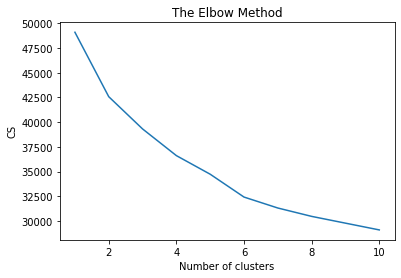

In [435]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(standardized_data)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [417]:
import seaborn as sns
data.columns

Index(['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres',
       'ordering', 'nconst', 'category', 'primaryName', 'primaryProfession',
       'knownForTitles', 'averageRating', 'numVotes', 'directors', 'writers',
       'cluster', 'Cluster'],
      dtype='object')

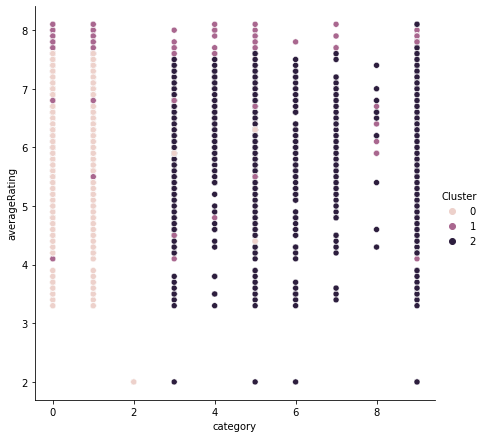

In [429]:
sns.relplot(
    x="category", y="averageRating", hue="Cluster", data=data, height=6,
);

In [436]:
# Visualization: Communicating Findings


In [ ]:
#TODO look at uniques again
